### Descripción del problema:
#### El problema del viajante (TSP) busca la ruta más corta que permita a un vendedor visitar cada ciudad una vez y regresar a la ciudad de origen. El objetivo es minimizar la distancia total de viaje.

In [44]:
from typing import List
from P1_TSP.util import generar_ciudades_con_distancias, plotear_ruta

#### ALGORITMO UTILIZADO: NEAREST NEIGHBOR

In [45]:
class TSP:
    # Se define el metodo inicializador (constructor) de la clase. La instancia de la clase se define con dos parámetros: ciudades y distancias entre las ciudades.
    def __init__(self, ciudades, distancias):
        self.ciudades = ciudades
        self.distancias = distancias
       
    # Se define el metodo para encontrar la mejor ruta (más corta)
    def encontrar_la_ruta_mas_corta(self):
        # Implementación del algoritmo nearest neighbor
        ciudades_restantes = list(self.ciudades.keys())  # Lista de ciudades por visitar
        ciudad_actual = ciudades_restantes.pop(0)  # Se toma el primer elemento de la lista de ciudades por visitar
        ruta = [ciudad_actual]  # Se define la ruta como una lista, iniciando en la primera ciudad por visitar
        distancia_total = 0  # Variable para acumular la distancia total

        # Iteración mientras queden ciudades por visitar
        while ciudades_restantes:
            # Se encuentra la ciudad más cercana a la ciudad actual que se está visitando
            ciudad_mas_cercana = min(ciudades_restantes, key = lambda ciudad: self.distancias[(ciudad_actual, ciudad)])
            # Se acumula la distancia de la ciudad actual a la ciudad más cercana
            distancia_total += self.distancias[(ciudad_actual, ciudad_mas_cercana)]
            ciudades_restantes.remove(ciudad_mas_cercana)  # Se elimina la ciudad más cercana visitada (de la lista de ciudades por visitar)
            ruta.append(ciudad_mas_cercana)  # Se agrega la ciudad más cercana visitada a la ruta
            ciudad_actual = ciudad_mas_cercana  # Se continúa con la siguiente ciudad por visitar 
            
        # Se suma la distancia de regreso a la ciudad de inicio
        distancia_total += self.distancias[(ciudad_actual, ruta[0])]
        # Una vez que se han visitado todas las ciudades de la lista, se completa la ruta regresando a la ciudad de inicio
        ruta.append(ruta[0])
        # Se devuelve la ruta (lista con todas las ciudades visitadas en un orden determinado) y la distancia total
        return ruta, distancia_total
        
    # Se define el metodo para visualizar la ruta (llamando a la función de gráficos definida en util.py)
    def plotear_resultado(self, ruta: List[str], mostrar_anotaciones: bool = True):
        plotear_ruta(self.ciudades, ruta, mostrar_anotaciones)

#### ALGORITMO UTILIZADO: BRUTE FORCE

In [46]:
from itertools import permutations
from typing import List

In [47]:
class TSP2:
    def __init__(self, ciudades, distancias):
        self.ciudades = ciudades
        self.distancias = distancias
        
    # Se define un metodo para calcular la distancia de la ruta. Este toma como argumento la ruta, la cual es una secuencia de ciudades
    def calcular_distancia_ruta(self, ruta):
        distancia_total = 0 # Inicialización de la distancia en cero. Esta variable acumulará la distancia total de la ruta
        for i in range(len(ruta) - 1): # Inicia un bucle que recorre la lista de ciudades en la ruta, excluyendo la última ciudad
            distancia_total += self.distancias[(ruta[i], ruta[i + 1])] # Para cada par de ciudades consecutivas en la ruta, suma la distancia correspondiente (obtenida del diccionario self.distancias) a distancia_total
        distancia_total += self.distancias[(ruta[-1], ruta[0])] # Añade la distancia de regreso de la última ciudad a la primera
        return distancia_total # Devuelve la distancia total calculada de la ruta
    
    # Implementación del algoritmo brute force
    def encontrar_la_ruta_mas_corta(self):
        
        # Inicializa mejor_ruta como None y mejor_distancia como infinito
        mejor_ruta = None
        mejor_distancia = float('inf')
        ciudades_lista = list(self.ciudades.keys()) # Se crea una lista de las ciudades
        
        # Se genera todas las permutaciones posibles de la lista de ciudades (utilizando la función 'permutations' que permite crear todas las combinaciones posibles de un conjunto)
        for perm in permutations(ciudades_lista):
            distancia = self.calcular_distancia_ruta(perm) # Se calcula la distancia total de la ruta actual (perm)
            if distancia < mejor_distancia: # Se comprueba si la distancia calculada es menor que la mejor distancia encontrada hasta el momento
                mejor_distancia = distancia # Si la distancia es mejor, se actualiza 'mejor_distancia' con el nuevo valor
                mejor_ruta = perm # Se actualiza 'mejor_ruta' con la ruta actual

        return mejor_ruta, mejor_distancia # Devuelve la mejor ruta encontrada y su distancia

    def plotear_resultado(self, ruta: List[str], mostrar_anotaciones: bool = True):
        plotear_ruta(self.ciudades, ruta, mostrar_anotaciones)

#### ALGORITMO UTILIZADO: ANT COLONY OPTIMIZATION

In [48]:
import random
import numpy as np
from typing import List, Dict

In [52]:
class AntColonyOptimization:
    
    # Se inicializa la instancia de la clase con las ciudades, distancias, número de hormigas, iteraciones, parámetros de importancia de feromona y distancia, y la tasa de evaporación 
    def __init__(self, ciudades: Dict[str, tuple], distancias: Dict[str, Dict[str, float]], n_ants: int, n_iterations: int, alpha: float, beta: float, evaporation_rate: float):
        self.ciudades = ciudades
        self.distancias = distancias
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.alpha = alpha  # Pheromone importance
        self.beta = beta    # Distance importance
        self.evaporation_rate = evaporation_rate
        self.pheromone = {edge: 1.0 for edge in distancias.keys()} # Se establece la feromona inicial en 1.0 para cada camino
        self.all_cities = list(ciudades.keys())
        
    # Se reinicia los niveles de feromona para todos los caminos a 1.0, preparándolos para una nueva iteración
    def _initialize_pheromone(self):
        self.pheromone = {edge: 1.0 for edge in self.distancias.keys()}

    # Se calcula la probabilidad de moverse de una ciudad a otra basándose en la cantidad de feromona en el camino y la distancia entre las ciudades (usando los parámetros alpha y beta)
    def _calculate_probability(self, from_city, to_city, visited):
        pheromone = self.pheromone[(from_city, to_city)]
        distance = self.distancias[(from_city, to_city)]
        return (pheromone ** self.alpha) * ((1.0 / distance) ** self.beta)
    
    # Se selecciona la siguiente ciudad a visitar, utilizando las probabilidades calculadas y evitando las ciudades ya visitadas
    def _select_next_city(self, current_city, visited):
        probabilities = []
        for city in self.all_cities:
            if city not in visited:
                probabilities.append(self._calculate_probability(current_city, city, visited))
            else:
                probabilities.append(0)
        probabilities = np.array(probabilities)
        probabilities /= probabilities.sum()
        return np.random.choice(self.all_cities, p = probabilities)

    # Se construye soluciones para cada hormiga, eligiendo aleatoriamente una ciudad inicial y luego seleccionando sucesivamente ciudades hasta que todas hayan sido visitadas (regresando finalmente a la ciudad de inicio)
    def _construct_solution(self):
        solutions = []
        for _ in range(self.n_ants):
            current_city = random.choice(self.all_cities)
            visited = [current_city]
            while len(visited) < len(self.all_cities):
                next_city = self._select_next_city(current_city, visited)
                visited.append(next_city)
                current_city = next_city
            visited.append(visited[0])  # Return to the start city
            solutions.append(visited)
        return solutions

    # Se actualiza los niveles de feromona en función de las soluciones encontradas. Se disminuye la cantidad de feromonas de todos los caminos y aumenta la feromona en los caminos que forman parte de las soluciones, inversamente proporcional a la longitud de la ruta.
    def _update_pheromone(self, solutions):
        for edge in self.pheromone.keys(): # Se itera sobre todos los caminos (edges) de la feromona
            self.pheromone[edge] *= (1 - self.evaporation_rate) # La feromona de cada camino se reduce en función de la tasa de evaporación 
        for solution in solutions: # Se itera sobre las soluciones encontradas por las hormigas y para cada solución, se calcula la longitud de la ruta 
            route_length = self._calculate_route_length(solution)
            for i in range(len(solution) - 1): 
                self.pheromone[(solution[i], solution[i + 1])] += 1.0 / route_length # Para cada par de ciudades consecutivas en la solución, se incrementa la feromona en el camino correspondiente. La feromona añadida es inversamente proporcional a la longitud de la ruta

    # Se calcula la longitud total de una ruta sumando las distancias entre ciudades consecutivas en la ruta
    def _calculate_route_length(self, route):
        return sum(self.distancias[(route[i], route[i + 1])] for i in range(len(route) - 1))

    # Algoritmo de optimización por colonias de hormigas 
    def encontrar_la_ruta_mas_corta(self) -> List[str]:
        self._initialize_pheromone()
        best_route = None
        best_length = float('inf')
        for _ in range(self.n_iterations): # Se ejecuta el algoritmo durante un número determinado de iteraciones
            solutions = self._construct_solution() # Se construye soluciones 
            self._update_pheromone(solutions) # Se actualiza la feromona
            for solution in solutions:
                route_length = self._calculate_route_length(solution)
                if route_length < best_length:
                    best_length = route_length
                    best_route = solution
        return best_route, best_length # Devuelve la mejor ruta y su longitud total

    def plotear_resultado(self, ruta: List[str], mostrar_anotaciones: bool = True):
        plotear_ruta(self.ciudades, ruta, mostrar_anotaciones)

#### GENERACION DE CASOS DE ESTUDIO

In [54]:
# Función caso 1
def study_case_1():
    # Se genera 10 ciudades aleatorias y sus distancias
    n_cities = 10 
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    
    # Instanciar las clases TSP, TSP2 y AntColonyOptimization
    tsp = TSP(ciudades, distancias)
    tsp2 = TSP2(ciudades, distancias)
    aco = AntColonyOptimization(ciudades, distancias, n_ants=10, n_iterations=100, alpha=1.0, beta=5.0, evaporation_rate=0.5)
    
    # Encontrar la ruta más corta utilizando el algoritmo Nearest neighbor y graficar los resultados
    ruta, distancia_total = tsp.encontrar_la_ruta_mas_corta()
    print('RESULTADO NEAREST NEIGHBOR')
    print(f"Mejor ruta: {ruta}, con distancia: {distancia_total}")
    tsp.plotear_resultado(ruta)
    
    print('\n\n___________________________________________________________________________________________\n\n')
    
    # Encontrar la ruta más corta utilizando el algoritmo Brute force y graficar los resultados
    mejor_ruta, mejor_distancia = tsp2.encontrar_la_ruta_mas_corta()
    print('RESULTADO BRUTE FORCE')
    print(f"Mejor ruta: {mejor_ruta}, con distancia: {mejor_distancia}")
    tsp2.plotear_resultado(mejor_ruta)
    
    print('\n\n___________________________________________________________________________________________\n\n')
    
    # Encontrar la ruta más corta utilizando el algoritmo Ant colonization y graficar los resultados
    best_route, best_length = aco.encontrar_la_ruta_mas_corta()
    print('RESULTADO ANT COLONIZATION')
    print(f"Mejor ruta: {best_route}, con distancia: {best_length}")
    aco.plotear_resultado(best_route)
    
# Función caso 2
def study_case_2():
    # Se genera 100 ciudades aleatorias y sus distancias
    n_cities = 100 
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    
    # Instanciar las clases TSP, TSP2 y AntColonyOptimization
    tsp = TSP(ciudades, distancias)
    tsp2 = TSP2(ciudades, distancias)
    aco = AntColonyOptimization(ciudades, distancias, n_ants=50, n_iterations=200, alpha=1.0, beta=5.0, evaporation_rate=0.5)
    
    # Encontrar la ruta más corta utilizando el algoritmo Nearest neighbor y graficar los resultados
    ruta, distancia_total = tsp.encontrar_la_ruta_mas_corta()
    print('RESULTADO NEAREST NEIGHBOR')
    print(f"Mejor ruta: {ruta}, con distancia: {distancia_total}")
    tsp.plotear_resultado(ruta, False)
    
    print('\n\n___________________________________________________________________________________________\n\n')
    
    # Encontrar la ruta más corta utilizando el algoritmo Ant colonization y graficar los resultados
    best_route, best_length = aco.encontrar_la_ruta_mas_corta()
    print('RESULTADO ANT COLONIZATION')
    print(f"Mejor ruta: {best_route}, con distancia: {best_length}")
    aco.plotear_resultado(best_route)
    
    print('\n\n___________________________________________________________________________________________\n\n')
    
    # Encontrar la ruta más corta utilizando el algoritmo Brute force y graficar los resultados
    mejor_ruta, mejor_distancia = tsp2.encontrar_la_ruta_mas_corta()
    print('RESULTADO BRUTE FORCE')
    print(f"Mejor ruta: {mejor_ruta}, con distancia: {mejor_distancia}")
    tsp2.plotear_resultado(mejor_ruta, False)

RESULTADO NEAREST NEIGHBOR
Mejor ruta: ['V7', 'E2', 'V4', 'O6', 'F7', 'K5', 'G2', 'H6', 'E3', 'Y5', 'V7'], con distancia: 455.7555844041934


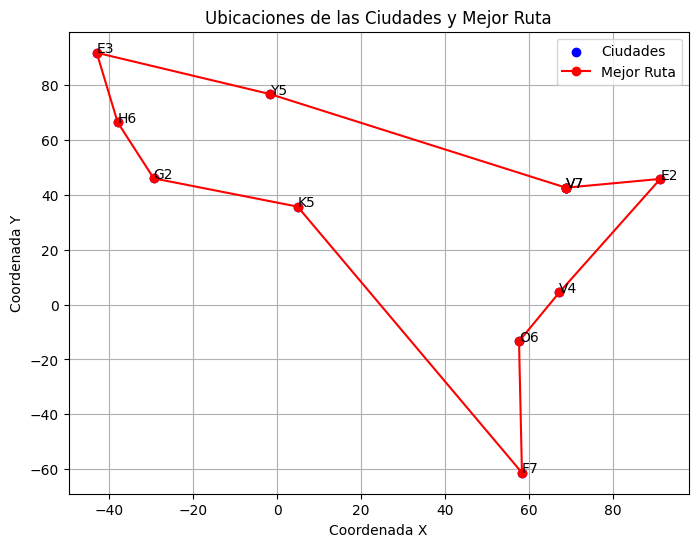



___________________________________________________________________________________________


RESULTADO BRUTE FORCE
Mejor ruta: ('V7', 'Y5', 'E3', 'H6', 'G2', 'K5', 'F7', 'O6', 'V4', 'E2'), con distancia: 455.75558440419337


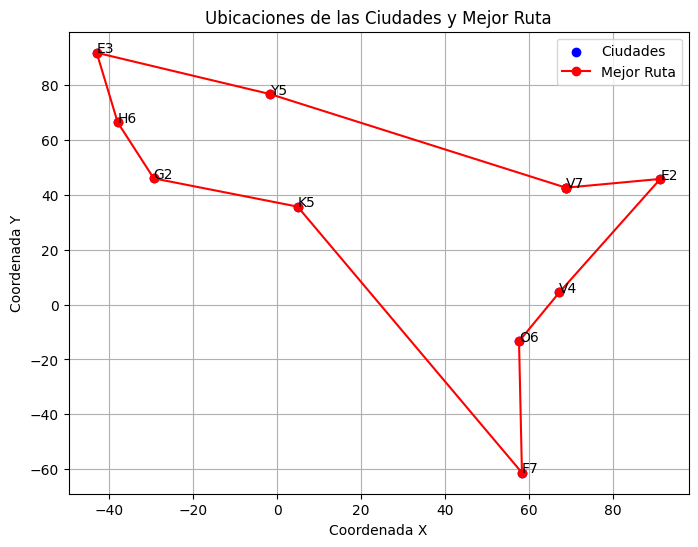



___________________________________________________________________________________________


RESULTADO ANT COLONIZATION
Mejor ruta: ['G2', 'H6', 'E3', 'Y5', 'V7', 'E2', 'V4', 'O6', 'F7', 'K5', 'G2'], con distancia: 455.75558440419337


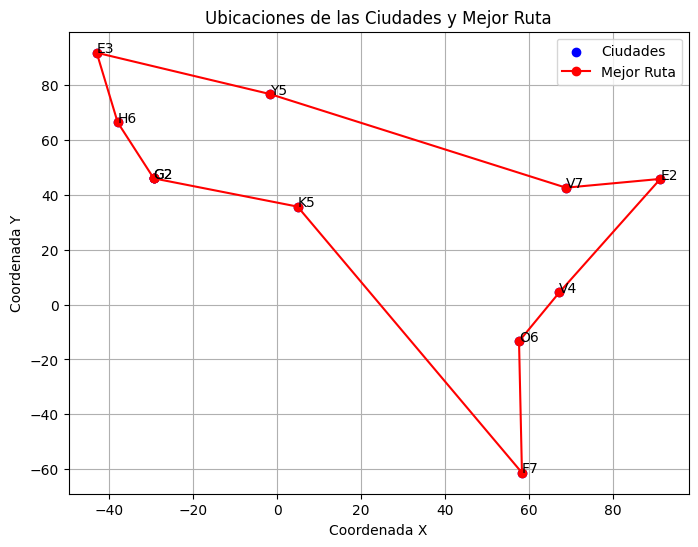

In [55]:
if __name__ == "__main__":
    study_case_1()

RESULTADO NEAREST NEIGHBOR
Mejor ruta: ['C5', 'T5', 'U6', 'G9', 'I5', 'B8', 'Z2', 'X1', 'A2', 'Z4', 'A5', 'J4', 'H9', 'W0', 'D8', 'K0', 'K6', 'W1', 'A4', 'D7', 'P5', 'U8', 'M4', 'F0', 'D1', 'U2', 'F5', 'U1', 'Z8', 'X9', 'R0', 'V1', 'P4', 'D3', 'H2', 'J0', 'R3', 'H4', 'V2', 'T7', 'C4', 'E7', 'J7', 'C7', 'T9', 'V9', 'S8', 'E5', 'X0', 'G4', 'H8', 'K3', 'G0', 'M1', 'N0', 'Y0', 'D0', 'L9', 'G8', 'F7', 'T8', 'X2', 'S3', 'C6', 'P0', 'M6', 'Q5', 'X3', 'S0', 'M0', 'U4', 'L7', 'P9', 'B9', 'O8', 'L3', 'C0', 'Y1', 'V8', 'D9', 'G5', 'K8', 'V0', 'Q7', 'C5'], con distancia: 1778.1509532065716


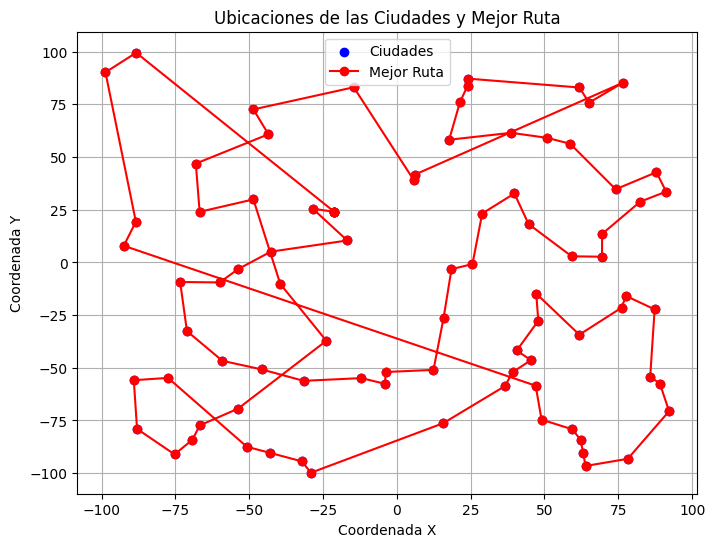



___________________________________________________________________________________________


RESULTADO ANT COLONIZATION
Mejor ruta: ['Q5', 'P0', 'M6', 'U8', 'M4', 'F0', 'U1', 'D1', 'U2', 'F5', 'X9', 'Z8', 'R3', 'J0', 'H4', 'R0', 'V1', 'V2', 'T7', 'C5', 'T5', 'U6', 'G9', 'S8', 'I5', 'B8', 'Z2', 'G5', 'K8', 'T9', 'V9', 'C7', 'J7', 'E7', 'V0', 'Q7', 'C4', 'D3', 'H2', 'P4', 'A4', 'D7', 'P5', 'K6', 'W1', 'K0', 'D8', 'W0', 'H9', 'J4', 'A5', 'E5', 'Z4', 'A2', 'X1', 'N0', 'M1', 'G0', 'K3', 'H8', 'G4', 'X0', 'Y0', 'D0', 'L9', 'G8', 'F7', 'T8', 'X2', 'S3', 'C6', 'D9', 'V8', 'Y1', 'C0', 'L3', 'O8', 'B9', 'P9', 'L7', 'U4', 'M0', 'S0', 'X3', 'Q5'], con distancia: 1531.3414490483585


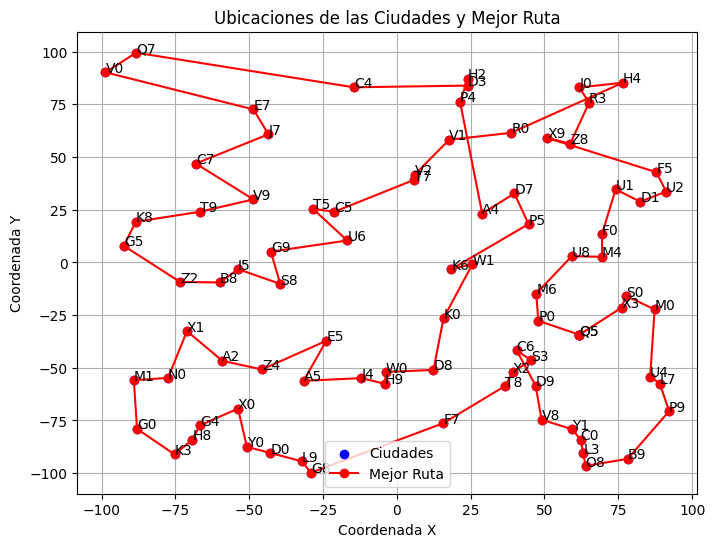



___________________________________________________________________________________________




KeyboardInterrupt: 

In [56]:
if __name__ == "__main__":
    study_case_2()